# M&Ms


In [ ]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
join = os.path.join
from fastai import *
from fastai.vision import *
import tensorflow as tf

import pandas as pd
import math
import random

In [ ]:
# Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes= 4

In [ ]:
# Capture training image info as a list
# --Takes ~35 minutes to execute--
train_images = []
for directory_path in glob.glob('/content/drive/MyDrive/FYP/MNMS/slices (1)/DATALOADER/images'): 
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

# Convert list to array for processing and expand dimensions to (n, 128, 128, 1)       
train_images = np.array(train_images)
train_images = np.expand_dims(train_images, axis = 3)

In [ ]:
# Capture mask/label info as a list
# --Takes ~25 minutes to execute--
train_masks = [] 
for directory_path in glob.glob('/content/drive/MyDrive/FYP/MNMS/slices (1)/DATALOADER/masks'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

# Convert list to array and expand dimensions to (n, 128, 128, 1) 
train_masks = np.array(train_masks)
train_masks = np.expand_dims(train_masks, axis = 3)

In [ ]:
# Normalize images (not masks)
train_images = train_images /255.

In [ ]:
print("Image data shape is: ", train_images.shape)
print("Mask data shape is: ", train_masks.shape)
print("Max pixel value in image is: ", train_images.max())
print("Labels in the mask are : ", np.unique(train_masks))

Image data shape is:  (3284, 128, 128, 1)
Mask data shape is:  (3284, 128, 128, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2 3]


In [ ]:
# Split training data
# --For quick testing - use only a small training sample--
# --For proper testing use 0.8/0.2 train/test split--
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.2, random_state = 21)

In [ ]:
print("Image data shape is: ", X_train.shape)
print("Mask data shape is: ", y_train.shape)
print("Max pixel value in image is: ", X_train.max())
print("Labels in the mask are : ", np.unique(y_train))

Image data shape is:  (2627, 128, 128, 1)
Mask data shape is:  (2627, 128, 128, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0 1 2 3]


In [ ]:
# One-hot to_categorical encoding for train_masks -> instead of (n, 128, 128, 1) -> (n, 128, 128, 4)
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train_cat.shape)
print(y_test_cat.shape)

(2627, 128, 128, 4)
(657, 128, 128, 4)


In [ ]:
X_train.shape

(2627, 128, 128, 1)

# SimSiam

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.interpolation

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 16
EPOCHS = 25
CROP_TO = 80
SEED = 25

PROJECT_DIM = 1024
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

Augmentation function

In [ ]:
def rand_crop(image):
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 1))
    image = tf.image.resize(image, (128,128), preserve_aspect_ratio=False, antialias=False, name=None)
    return image

def rand_flip_lr(image):
    image = tf.image.random_flip_left_right(image)
    return image

def rand_brightness_contrast(x):
    x = tf.image.random_brightness(x,max_delta=0.5,seed=1)
    x = tf.image.random_contrast(x,lower=0.5,upper=1.5,seed=1)
    return x

#def rand_rotation(x):
#    x = tf.keras.preprocessing.image.random_rotation(x, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
#    return x


#def rand_rotation(x):
#    angles = [-30,30]
#    random_angle = np.random.uniform(angles[0], angles[1])
#    x = scipy.ndimage.interpolation.rotate(x, reshape=False, angle=random_angle, axes=(1,0), order=1)
#    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = rand_crop(image)
    image = rand_flip_lr(image)
    image = random_apply(rand_brightness_contrast, image, p=0.9)
#    image = random_apply(rand_rotation, image, p=0.7)
    return image

Convert to TensforFlow Dataset object

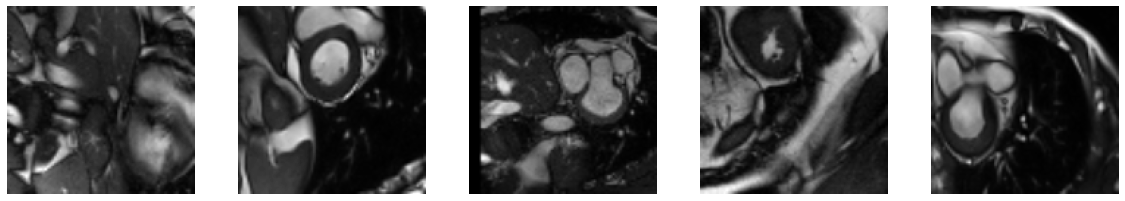

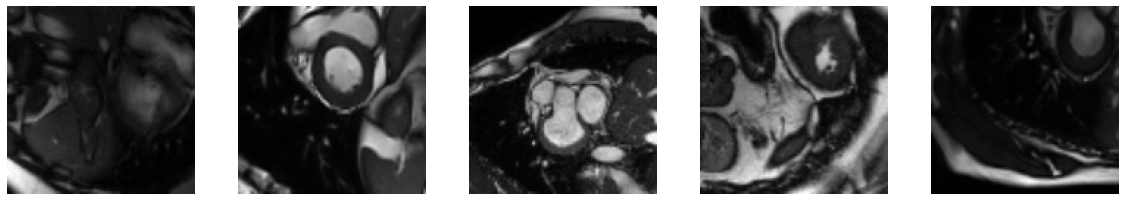

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(20, 20))
for n in range(5):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n][:,:,0], cmap='gray')
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(20, 20))
for n in range(5):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n][:,:,0], cmap='gray')
    plt.axis("off")
plt.show()

Define the encoder and predictor

In [ ]:
# Global contrastive loss with encoder network e(.)
# e(.) consists of 4 convolutional blocks, each consisting of two 3x3 convolutions followed by a 2x2 maxpooling layer with stride 2

# Building Unet by dividing encoder and decoder into blocks
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Flatten
from keras.layers import Activation, MaxPool2D, Concatenate
import tensorflow as tf

SIZE_Y = 128
SIZE_X = 128
IMG_CHANNELS = 1
input_shape = (SIZE_Y, SIZE_X, IMG_CHANNELS)

# Convolution block: consists of two 3x3 convolutions
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p 

# Create the encoder and add 2 layer MLP (projection head)
def create_encoder():
    inputs = layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

# Projection head
    x = keras.layers.Flatten()(inputs=b1)
    x = keras.layers.Dense(PROJECT_DIM, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dense(PROJECT_DIM, use_bias=False)(x)
    outputs = keras.layers.BatchNormalization()(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='encoder_with_projection_head')

    return model

# PROJECT_DIM = 1024 (output from projector head)
# LATENT_DIM = 512
# WEIGHT_DECAY = 0.0005

def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

Define the loss function

In [ ]:
def compute_loss(p, z):
    # Stop-grad operation important in preventing representation collapse
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimise)
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Epoch 1/25
165/165 [==============================] - 108s 425ms/step - loss: -0.9344
Epoch 2/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9700
Epoch 3/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9744
Epoch 4/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9772
Epoch 5/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9795
Epoch 6/25
165/165 [==============================] - 67s 404ms/step - loss: -0.9813
Epoch 7/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9829
Epoch 8/25
165/165 [==============================] - 66s 403ms/step - loss: -0.9839
Epoch 9/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9847
Epoch 10/25
165/165 [==============================] - 67s 403ms/step - loss: -0.9852
Epoch 11/25
165/165 [==============================] - 67s 404ms/step - loss: -0.9856
Epoch 12/25
165/165 [==============================] - 67s 404

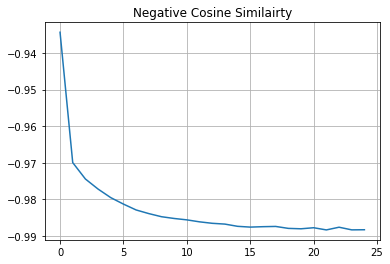

In [ ]:
# Create a cosine decay learning scheduler.
num_training_samples = len(X_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(create_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))

#simsiam.encoder.load_weights('/content/drive/MyDrive/FYP/MNMS/pretrained-25epochs-17-Oct.hdf5')

history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [ ]:
simsiam.encoder.save_weights('/content/drive/MyDrive/FYP/MNMS/pretrained-50epochs.hdf5')

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

SIZE_Y = 128
SIZE_X = 128
input_shape = (SIZE_Y, SIZE_X, 1)

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block: Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes

    model = Model(inputs, outputs, name="U-Net")
    return model

# Build model
unet_pretrained = build_unet(input_shape, n_classes=4)

In [ ]:
# set weights from pre-trained encoder (first 35 layers) to the encoder part of U-Net
for l1, l2 in zip(unet_pretrained.layers[0:35],  simsiam.encoder.layers[0:35]):
    l1.set_weights(l2.get_weights())

# freeze the encoder 
#for layer in unet_pretrained.layers[0:35]:
#    layer.trainable=True

unet_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
unet_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unet_pretrained.load_weights('/content/drive/MyDrive/FYP/MNMS/simsiam-50epochs-pretrained50epochs.hdf5')

In [ ]:
# We first create labeled 'Dataset' objects.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (rand_flip_lr(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

history1 = unet_pretrained.fit(
    train_ds, validation_data=test_ds, epochs=50, callbacks=[early_stopping]
)

Epoch 1/50
165/165 [==============================] - 81s 488ms/step - loss: 0.0060 - accuracy: 0.9974 - val_loss: 0.0183 - val_accuracy: 0.9950
Epoch 2/50
165/165 [==============================] - 81s 489ms/step - loss: 0.0061 - accuracy: 0.9974 - val_loss: 0.0182 - val_accuracy: 0.9951
Epoch 3/50
165/165 [==============================] - 81s 490ms/step - loss: 0.0059 - accuracy: 0.9975 - val_loss: 0.0176 - val_accuracy: 0.9951
Epoch 4/50
165/165 [==============================] - 81s 489ms/step - loss: 0.0069 - accuracy: 0.9971 - val_loss: 0.0177 - val_accuracy: 0.9947
Epoch 5/50
165/165 [==============================] - 81s 489ms/step - loss: 0.0076 - accuracy: 0.9969 - val_loss: 0.0169 - val_accuracy: 0.9949
Epoch 6/50
165/165 [==============================] - 81s 489ms/step - loss: 0.0064 - accuracy: 0.9973 - val_loss: 0.0183 - val_accuracy: 0.9946
Epoch 7/50
165/165 [==============================] - 81s 489ms/step - loss: 0.0064 - accuracy: 0.9973 - val_loss: 0.0166 - val_ac

In [ ]:
unet_pretrained.save_weights('/content/drive/MyDrive/FYP/MNMS/simsiam-100epochs-pretrained50epochs.hdf5')

# Validation testing with new vendors


In [ ]:
val_path = '/content/drive/MyDrive/FYP/MNMS/OpenDataset/Validation/'
val_image_output = '/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor/'
val_mask_output = '/content/drive/MyDrive/FYP/MNMS/Validation slices/masks_vendor/'

# Pandas read csv file containing ED and ES values
df = pd.read_csv('/content/drive/MyDrive/FYP/MNMS/OpenDataset/201014_M&Ms_Dataset_Information_-_opendataset.csv')

SIZE_Y = 128
SIZE_X = 128

# Capture training image info as a list
val_images = []
for directory_path in glob.glob('/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor'): 
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)

# Convert list to array for processing and expand dimensions to (n, 128, 128, 1)       
val_images = np.array(val_images)
val_images = np.expand_dims(val_images, axis = 3)

# Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob('/content/drive/MyDrive/FYP/MNMS/Validation slices/masks_vendor'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  # Otherwise ground truth changes due to interpolation
        val_masks.append(mask)

# Convert list to array and expand dimensions to (n, 128, 128, 1) 
val_masks = np.array(val_masks)
val_masks = np.expand_dims(val_masks, axis = 3)

# Normalize images (not masks)
val_images = val_images /255.

val_img_A = []
val_img_B = []
val_img_C = []
val_img_D = []

# Create the image vendor lists
for filename in os.listdir('/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor'):
    if filename.startswith("vA_"): 
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_A.append(img)
    if filename.startswith("vB_"):
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_B.append(img)
    if filename.startswith("vC_"):
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_C.append(img)
    if filename.startswith("vD_"):
         img = cv2.imread((val_image_output + filename), 0)
         img = cv2.resize(img, (SIZE_Y, SIZE_X))
         val_img_D.append(img)         


val_img_A = np.array(val_img_A)
val_img_A = np.expand_dims(val_img_A, axis = 3)
val_img_B = np.array(val_img_B)
val_img_B = np.expand_dims(val_img_B, axis = 3)
val_img_C = np.array(val_img_C)
val_img_C = np.expand_dims(val_img_C, axis = 3)
val_img_D = np.array(val_img_D)
val_img_D = np.expand_dims(val_img_D, axis = 3)

# Normalize images (not masks)
val_img_A = val_img_A /255.
val_img_B = val_img_B /255.
val_img_C = val_img_C /255.
val_img_D = val_img_D /255.

val_mask_A = []
val_mask_B = []
val_mask_C = []
val_mask_D = []

# Create the mask vendor lists
for filename in os.listdir('/content/drive/MyDrive/FYP/MNMS/Validation slices/images_vendor'):
    if filename.startswith("vA_"): 
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_A.append(mask)
    if filename.startswith("vB_"):
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_B.append(mask)
    if filename.startswith("vC_"):
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_C.append(mask)
    if filename.startswith("vD_"):
         mask = cv2.imread((val_mask_output + filename), 0)
         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
         val_mask_D.append(mask)         


val_mask_A = np.array(val_mask_A)
val_mask_A = np.expand_dims(val_mask_A, axis = 3)
val_mask_B = np.array(val_mask_B)
val_mask_B = np.expand_dims(val_mask_B, axis = 3)
val_mask_C = np.array(val_mask_C)
val_mask_C = np.expand_dims(val_mask_C, axis = 3)
val_mask_D = np.array(val_mask_D)
val_mask_D = np.expand_dims(val_mask_D, axis = 3)

val_imgs_all = [val_images, val_img_A, val_img_B, val_img_C, val_img_D]
val_imgs_all = np.array(val_imgs_all, dtype=object)

val_masks_all = [val_masks, val_mask_A, val_mask_B, val_mask_C, val_mask_D]
val_masks_all = np.array(val_masks_all, dtype=object)

names = ["All", "A", "B", "C", "D"]

In [ ]:
y_pred_argmax_all = []

for i in range(len(val_imgs_all)):
    y_pred=unet_pretrained.predict(val_imgs_all[i])
    y_pred_argmax=np.argmax(y_pred, axis=3)
    y_pred_argmax_all.append(y_pred_argmax)

# Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)

for i in range(len(val_imgs_all)):
    IOU_keras.update_state(val_masks_all[i][:,:,:,0], y_pred_argmax_all[i])
    print("Mean IoU " + names[i] +  ":       ", IOU_keras.result().numpy())
    values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
    class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
    class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
    class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
    class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
#   print("IoU for class1 is: ", class1_IoU) # background class not important
    print("IoU for class2 is: ", class2_IoU)
    print("IoU for class3 is: ", class3_IoU)
    print("IoU for class4 is: ", class4_IoU)
    print("\n")

Mean IoU All:        0.82529074
IoU for class2 is:  0.83522326
IoU for class3 is:  0.6946984
IoU for class4 is:  0.7747091


Mean IoU A:        0.8158306
IoU for class2 is:  0.8183176
IoU for class3 is:  0.686389
IoU for class4 is:  0.7624865


Mean IoU B:        0.8124468
IoU for class2 is:  0.8061883
IoU for class3 is:  0.6771861
IoU for class4 is:  0.7700208


Mean IoU C:        0.80351335
IoU for class2 is:  0.78157485
IoU for class3 is:  0.6700341
IoU for class4 is:  0.7660881


Mean IoU D:        0.7955441
IoU for class2 is:  0.77069837
IoU for class3 is:  0.65358883
IoU for class4 is:  0.7615647




In [ ]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def mean_dice_coef(y_true, y_pred_bin):
    # Shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    # Includes background
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel

def channel_dice_coef(y_true, y_pred_bin):
    # Shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    channel_dice_coef = 0.
    channel_dsc = []
    for i in range(channel_num):
        for j in range(batch_size):
            channel_dice = single_dice_coef(y_true[j, :, :, i], y_pred_bin[j, :, :, i])
            channel_dice_coef += channel_dice/(batch_size)
        channel_dsc.append(channel_dice_coef)
        channel_dice_coef = 0.
    return channel_dsc

def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

from tensorflow.keras.utils import to_categorical
y_pred_cat_all = []
val_masks_cat_all = []

for i in range(len(y_pred_argmax_all)):
    y_pred = np.expand_dims(y_pred_argmax_all[i], axis=3)
    y_pred_cat = to_categorical(y_pred, num_classes=n_classes)
    y_pred_cat = y_pred_cat.reshape((y_pred.shape[0], y_pred.shape[1], y_pred.shape[2], n_classes))
    y_pred_cat_all.append(y_pred_cat)
    val_masks_cat = to_categorical(val_masks_all[i], num_classes=n_classes)
    val_masks_cat = val_masks_cat.reshape((val_masks_all[i].shape[0], val_masks_all[i].shape[1], val_masks_all[i].shape[2], n_classes))
    val_masks_cat_all.append(val_masks_cat)

for i in range(len(y_pred_cat_all)):
    print("Dice scores " + names[i] + ":")
    print(channel_dice_coef(val_masks_cat_all[i], y_pred_cat_all[i])[1:]) # print from class 1 as bg. not important
    print("Mean DS (inc. bg.): ", mean_dice_coef(val_masks_cat_all[i], y_pred_cat_all[i]))
    print("\n")

Dice scores All:
[0.8761158926636093, 0.801362252433097, 0.8542264595834576]
Mean DS (inc. bg.):  0.8824871780595681


Dice scores A:
[0.8266566308737602, 0.7908278895215056, 0.8193569288508739]
Mean DS (inc. bg.):  0.8582926264048386


Dice scores B:
[0.803392300763079, 0.7655303588207059, 0.8599710422309094]
Mean DS (inc. bg.):  0.856910645053531


Dice scores C:
[0.7501622065086151, 0.7565911234204831, 0.8396144983349416]
Mean DS (inc. bg.):  0.8361126716600191


Dice scores D:
[0.7863395231622808, 0.72772637034566, 0.8387326102716632]
Mean DS (inc. bg.):  0.837713787168102




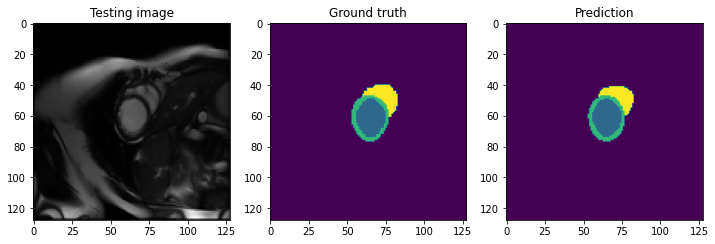

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (unet_pretrained.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Ground truth')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_img)
plt.show()